# Assignment 2: Generative Adversarial Network (GAN) {-}

This assignment aims at familiarizing you with training, validating and testing a Generative Adversarial Network (GAN). Here are the requirements of the assignment:

- Load the dataset. To save training time, you only need to load and work on ONE image class of your choice.
- Process the images.
- Build a GAN architecture consisting of at least one (01) Discriminator and one (01) Generator of which the architectures are of your choice. You are encouraged to customize the network architectures to be different from the ones demonstrated in the demo code. There are two levels of image generation requirements:
    - First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN. You are free to choose which class of object you are interested in working on.
    - Second-level requirement: train and generate images for ONE class of the dataset using the mechanism of ProGAN. In this requirement, you do not need to strictly follow the implementation in the ProGAN paper. Feel free to construct a light version (a simple incremental network architecture) of it yourself. NOTE: it is fine to try and fail (i.e., you may not be able to generate good quality images), but at least you give it a try.
- Visualize the model behaviors during the training.
- Visualize the generated images.

The dataset you will be working on is CIFAR-10. This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

Here follows some data samples in the dataset:

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment2-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named ADL-\<StudentID>-Assignment2 (e.g., ADL-2012345-Assigment2) and then compressed with the same name.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. It is a plus if you have modeling steps other than the basic requirements and achieve an excellent model performance. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras import Model

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# First-level requirement
First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN. You are free to choose which class of object you are interested in working on.

In [19]:
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 )
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train)
cifar10_test = tfds.as_numpy(cifar10_test)

# Seperate feature X and label Y
X_train, y_train = cifar10_train["image"], cifar10_train["label"]
X_test, y_test = cifar10_test["image"], cifar10_test["label"]

# Print shapes of the entire training and test set of CIFAR 10
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000,)
y_test shape: (10000,)


In [20]:
# Get samples  of a certain label
label = 5 # Class '1' is car. You may change this label to another class label. I changed in dogs
train_indices = np.where(y_train == label) # Get indices of the label
train_set = X_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = X_train[test_indices] # Get test samples of the label

# Print shapes of datasets of the selected class
print("train_set shape of the selected class: " + str(train_set.shape))
print("test_set shape of the selected class: " + str(test_set.shape))

# NOTE: training a GAN does not require to have train/test split. All data samples of the training and the test set are used as real data samples.
# You should merge the training and the test set to get more real data samples, i.e., merge the train_set and the test_set to one dataset which is the real dataset.

train_set shape of the selected class: (5000, 32, 32, 3)
test_set shape of the selected class: (1000, 32, 32, 3)


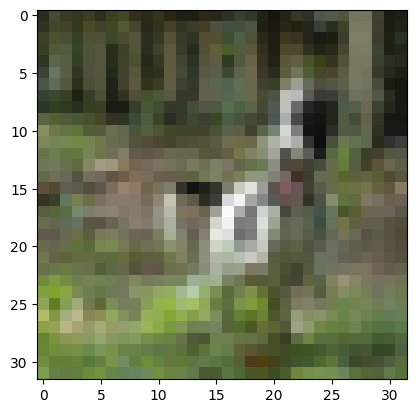

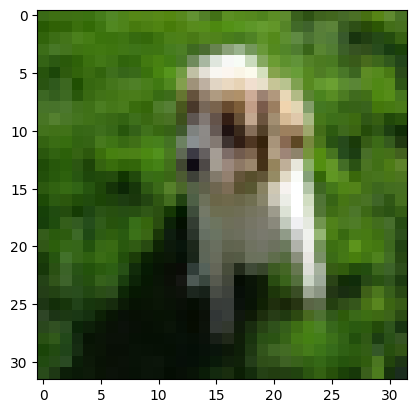

In [21]:
# Visualize some data samples of class '1' (car)
import matplotlib.pyplot as plt
imgplot = plt.imshow(train_set[0])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Conv2DTranspose, LeakyReLU, Reshape, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam


def Generator(latent_dim):

  model = Sequential()
  n_nodes = 256*4*4
  model.add(Dense(input_dim=latent_dim, units = n_nodes))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))

	# upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

	# upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

	# upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

	# output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

  return model

generator = Generator(128)
generator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4096)              528384    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                           

In [23]:
def Discriminator(in_shape = (32,32,3)):
  model = Sequential()

  model.add(Conv2D(64 , (3,3), strides = (2,2), padding = 'same', input_shape = in_shape))
  model.add(LeakyReLU(alpha=0.2))

	# downsample

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

	# downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

	# downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

	# classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

discriminator = Discriminator()
discriminator.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 2, 2, 256)        

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
def GAN(g_model, d_model):
  model = Sequential()
  model.add(g_model)
  model.add(d_model)

  return model


In [25]:
from numpy.random import randn, randint
from numpy import zeros, ones, vstack, expand_dims


def norm_sample():
  X = X_train.astype('float32') # Change the value to float 32 for normalization
  X = (X - 127.5)/127.5
  return X

def sample_generate(ds, sample_num): # Generate random sample from the real dataset 
  index = randint(0, ds.shape[0], sample_num)
  X = ds[index]
  y = ones((sample_num, 1))
  return X,y

In [26]:
def latent_point(latent_dim, sample_num):
  x_in = randn(latent_dim*sample_num)
  x_in = x_in.reshape(sample_num, latent_dim)
  return x_in

def gen_fake(g_model, latent_dim, sample_num): #Function to generate fake samples 
  x_in = latent_point(latent_dim, sample_num)
  X = g_model.predict(x_in)
  y = zeros((sample_num, 1))
  return X,y

In [27]:
# Create and save a plot of generated images
def save_plot(samples, epoch, n=10):
    # Define a plot of (n rows, n columns)
    for i in range(n * n):
        # (1+i) is the index position on a grid with nrows rows and ncols columns. Index starts at 1 in the upper left corner and increases to the right.
        plt.subplot(n, n, 1+i)
        plt.axis('off') # Disable axis
        plt.imshow(samples[i, :, :, :]) # Plot the sample i with reversed gay color map
    filename = 'Plot_epoch_%03d.png' % (epoch+1)
    plt.savefig(filename) # Save plot to file
    plt.close() # Close the plot

In [28]:
# Saving the model so that I can continue training after Colab crashes/OOM
def saveModel(D, G, GAN, atEpoch):
    DName = 'D_epoch_%03d' % (atEpoch)
    GName = 'G_epoch_%03d' % (atEpoch)
    GANName = 'GAN_epoch_%03d' % (atEpoch)

    D.save(DName, save_format = 'tf')
    G.save(GName, save_format = 'tf')
    GAN.save(GANName, save_format = 'tf')
    pass

In [29]:
# Train the Generator and the Discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=201, n_batch=4096):
    bat_per_epo = int(dataset.shape[0] / n_batch) # Number of iterations per epoch
    half_batch = int(n_batch / 2) # A batch to the Discriminator contains real samples (half-batch) and fake samples (half-batch)

    d_loss_values = [] # Array containing Discriminator loss over iterations
    g_loss_values = [] # Array containing Generator loss over iterations

    # Number of epochs
    for i in range(n_epochs):
        # Number of iterations
        for j in range(bat_per_epo):

            # Randomly get half_batch real data samples from the real dataset
            X_real, y_real = sample_generate(dataset, half_batch)
            # Generate half_batch fake data samples
            X_fake, y_fake = gen_fake(g_model, latent_dim, half_batch)
            # Create training set for the discriminator: half-batch real and half-batch fake
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)

            # Generate random latent vectors as input for Generator
            X_gan = latent_point(latent_dim, n_batch)
            # Generate inverted labels for the fake samples to train the Generator
            y_gan = ones((n_batch, 1))
            # Train the Generator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Training log after every iteration
            print('Epoch %d, Iteration %d/%d, D_loss = %.3f, G_loss = %.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # Add loss values to historical arrays
            d_loss_values.append(d_loss)
            g_loss_values.append(g_loss)

        # Plot the generated images and save the model every certain number of epochs
        if (i+1) % 10 == 0: # every 10 epochs
            X_fake, _ = gen_fake(g_model, latent_dim, 100) # Generate 100 fake data samples using the Generator. Pixel values are in [0,1]
            save_plot(X_fake, i, n=10) # Plot a grid of 10x10 fake samples and save to file at epoch i
            saveModel(d_model, g_model, gan_model, i) # Saving all three models

    return d_loss_values, g_loss_values # Return the loss arrays of Generator and Discriminator

In [30]:
# Import optimization library
from keras.optimizers import Adam, SGD

# Size of the latent space
latent_dim = 128
epochs = 301
batch_size = 1024

# Initialize an optimizer. Pick one.
opt = Adam(learning_rate=0.0002, beta_1=0.5) # Adam optimizer with customized values (for the best result)
# opt = Adam() # Adam optimizer with default values
# opt = SGD() # SGD optimizer with default values

# Create the Discriminator
d_model = Discriminator()
d_model.trainable = True
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Create the Generator
g_model = Generator(latent_dim)

# Create the GAN
d_model.trainable = False
gan_model = GAN(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=opt)

# Load real image data from the MNIST dataset
dataset = norm_sample()

# Train the GAN
d_losses, g_losses = train(g_model, d_model, gan_model, dataset, latent_dim, epochs, batch_size)

16/16 [==============================] - 0s 8ms/step
Epoch 1, Iteration 1/48, D_loss = 0.697, G_loss = 0.693
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 2/48, D_loss = 0.679, G_loss = 0.691
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 3/48, D_loss = 0.664, G_loss = 0.686
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 4/48, D_loss = 0.646, G_loss = 0.674
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 5/48, D_loss = 0.627, G_loss = 0.654
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 6/48, D_loss = 0.613, G_loss = 0.645
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 7/48, D_loss = 0.586, G_loss = 0.674
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 8/48, D_loss = 0.546, G_loss = 0.725
16/16 [==============================] - 0s 4ms/step
Epoch 1, Iteration 9/48, D_loss = 0.531, G_loss = 0.750
16/16 [============

16/16 [==============================] - 0s 8ms/step
Epoch 11, Iteration 1/48, D_loss = 0.661, G_loss = 1.059
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 2/48, D_loss = 0.642, G_loss = 1.097
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 3/48, D_loss = 0.622, G_loss = 1.093
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 4/48, D_loss = 0.615, G_loss = 1.101
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 5/48, D_loss = 0.642, G_loss = 1.193
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 6/48, D_loss = 0.670, G_loss = 1.058
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 7/48, D_loss = 0.680, G_loss = 1.001
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 8/48, D_loss = 0.709, G_loss = 0.988
16/16 [==============================] - 0s 4ms/step
Epoch 11, Iteration 9/48, D_loss = 0.706, G_loss = 1.002
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 21, Iteration 1/48, D_loss = 0.662, G_loss = 1.198
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 2/48, D_loss = 0.672, G_loss = 1.153
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 3/48, D_loss = 0.656, G_loss = 1.185
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 4/48, D_loss = 0.618, G_loss = 1.225
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 5/48, D_loss = 0.604, G_loss = 1.307
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 6/48, D_loss = 0.677, G_loss = 1.312
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 7/48, D_loss = 0.674, G_loss = 1.370
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 8/48, D_loss = 0.654, G_loss = 1.390
16/16 [==============================] - 0s 4ms/step
Epoch 21, Iteration 9/48, D_loss = 0.610, G_loss = 1.389
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 31, Iteration 1/48, D_loss = 0.650, G_loss = 0.990
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 2/48, D_loss = 0.639, G_loss = 1.034
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 3/48, D_loss = 0.627, G_loss = 1.026
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 4/48, D_loss = 0.631, G_loss = 0.984
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 5/48, D_loss = 0.673, G_loss = 0.922
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 6/48, D_loss = 0.704, G_loss = 0.872
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 7/48, D_loss = 0.735, G_loss = 0.803
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 8/48, D_loss = 0.767, G_loss = 0.748
16/16 [==============================] - 0s 4ms/step
Epoch 31, Iteration 9/48, D_loss = 0.772, G_loss = 0.730
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 41, Iteration 1/48, D_loss = 0.668, G_loss = 0.929
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 2/48, D_loss = 0.660, G_loss = 0.880
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 3/48, D_loss = 0.658, G_loss = 0.881
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 4/48, D_loss = 0.643, G_loss = 0.870
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 5/48, D_loss = 0.648, G_loss = 0.858
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 6/48, D_loss = 0.641, G_loss = 0.846
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 7/48, D_loss = 0.637, G_loss = 0.838
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 8/48, D_loss = 0.645, G_loss = 0.855
16/16 [==============================] - 0s 4ms/step
Epoch 41, Iteration 9/48, D_loss = 0.633, G_loss = 0.860
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 51, Iteration 1/48, D_loss = 0.601, G_loss = 0.940
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 2/48, D_loss = 0.584, G_loss = 0.921
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 3/48, D_loss = 0.575, G_loss = 0.986
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 4/48, D_loss = 0.545, G_loss = 0.919
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 5/48, D_loss = 0.544, G_loss = 1.030
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 6/48, D_loss = 0.539, G_loss = 1.009
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 7/48, D_loss = 0.525, G_loss = 1.099
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 8/48, D_loss = 0.539, G_loss = 1.001
16/16 [==============================] - 0s 4ms/step
Epoch 51, Iteration 9/48, D_loss = 0.574, G_loss = 1.133
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 61, Iteration 1/48, D_loss = 0.615, G_loss = 0.914
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 2/48, D_loss = 0.613, G_loss = 0.898
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 3/48, D_loss = 0.612, G_loss = 0.895
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 4/48, D_loss = 0.610, G_loss = 0.895
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 5/48, D_loss = 0.609, G_loss = 0.926
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 6/48, D_loss = 0.610, G_loss = 0.856
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 7/48, D_loss = 0.616, G_loss = 0.828
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 8/48, D_loss = 0.635, G_loss = 0.881
16/16 [==============================] - 0s 4ms/step
Epoch 61, Iteration 9/48, D_loss = 0.630, G_loss = 0.851
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 71, Iteration 1/48, D_loss = 0.587, G_loss = 0.898
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 2/48, D_loss = 0.594, G_loss = 0.921
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 3/48, D_loss = 0.604, G_loss = 1.016
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 4/48, D_loss = 0.613, G_loss = 0.990
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 5/48, D_loss = 0.606, G_loss = 0.960
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 6/48, D_loss = 0.625, G_loss = 0.949
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 7/48, D_loss = 0.637, G_loss = 0.964
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 8/48, D_loss = 0.641, G_loss = 0.937
16/16 [==============================] - 0s 4ms/step
Epoch 71, Iteration 9/48, D_loss = 0.662, G_loss = 0.952
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 81, Iteration 1/48, D_loss = 0.638, G_loss = 0.884
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 2/48, D_loss = 0.629, G_loss = 0.884
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 3/48, D_loss = 0.607, G_loss = 0.875
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 4/48, D_loss = 0.594, G_loss = 0.895
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 5/48, D_loss = 0.576, G_loss = 0.963
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 6/48, D_loss = 0.554, G_loss = 0.937
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 7/48, D_loss = 0.576, G_loss = 1.002
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 8/48, D_loss = 0.570, G_loss = 1.045
16/16 [==============================] - 0s 4ms/step
Epoch 81, Iteration 9/48, D_loss = 0.585, G_loss = 0.918
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 91, Iteration 1/48, D_loss = 0.699, G_loss = 0.857
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 2/48, D_loss = 0.687, G_loss = 0.848
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 3/48, D_loss = 0.681, G_loss = 0.838
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 4/48, D_loss = 0.656, G_loss = 0.822
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 5/48, D_loss = 0.640, G_loss = 0.860
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 6/48, D_loss = 0.611, G_loss = 0.897
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 7/48, D_loss = 0.592, G_loss = 0.882
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 8/48, D_loss = 0.625, G_loss = 0.890
16/16 [==============================] - 0s 4ms/step
Epoch 91, Iteration 9/48, D_loss = 0.658, G_loss = 0.917
16/16 [===

16/16 [==============================] - 0s 8ms/step
Epoch 101, Iteration 1/48, D_loss = 0.654, G_loss = 0.805
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 2/48, D_loss = 0.637, G_loss = 0.812
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 3/48, D_loss = 0.663, G_loss = 0.816
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 4/48, D_loss = 0.644, G_loss = 0.815
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 5/48, D_loss = 0.646, G_loss = 0.805
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 6/48, D_loss = 0.660, G_loss = 0.811
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 7/48, D_loss = 0.659, G_loss = 0.819
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 8/48, D_loss = 0.651, G_loss = 0.805
16/16 [==============================] - 0s 4ms/step
Epoch 101, Iteration 9/48, D_loss = 0.650, G_loss = 0.792
1

16/16 [==============================] - 0s 7ms/step
Epoch 111, Iteration 1/48, D_loss = 0.645, G_loss = 0.836
16/16 [==============================] - 0s 4ms/step
Epoch 111, Iteration 2/48, D_loss = 0.629, G_loss = 0.805
16/16 [==============================] - 0s 4ms/step
Epoch 111, Iteration 3/48, D_loss = 0.673, G_loss = 0.791
16/16 [==============================] - 0s 4ms/step
Epoch 111, Iteration 4/48, D_loss = 0.669, G_loss = 0.865
16/16 [==============================] - 0s 4ms/step
Epoch 111, Iteration 5/48, D_loss = 0.672, G_loss = 0.861
16/16 [==============================] - 0s 4ms/step
Epoch 111, Iteration 6/48, D_loss = 0.647, G_loss = 0.769
16/16 [==============================] - 0s 4ms/step
Epoch 111, Iteration 7/48, D_loss = 0.664, G_loss = 0.809
16/16 [==============================] - 0s 5ms/step
Epoch 111, Iteration 8/48, D_loss = 0.658, G_loss = 0.799
16/16 [==============================] - 0s 4ms/step
Epoch 111, Iteration 9/48, D_loss = 0.650, G_loss = 0.799
1

16/16 [==============================] - 0s 8ms/step
Epoch 121, Iteration 1/48, D_loss = 0.672, G_loss = 0.783
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 2/48, D_loss = 0.669, G_loss = 0.764
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 3/48, D_loss = 0.668, G_loss = 0.752
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 4/48, D_loss = 0.665, G_loss = 0.734
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 5/48, D_loss = 0.679, G_loss = 0.722
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 6/48, D_loss = 0.668, G_loss = 0.723
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 7/48, D_loss = 0.689, G_loss = 0.732
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 8/48, D_loss = 0.676, G_loss = 0.733
16/16 [==============================] - 0s 4ms/step
Epoch 121, Iteration 9/48, D_loss = 0.669, G_loss = 0.727
1

16/16 [==============================] - 0s 8ms/step
Epoch 131, Iteration 1/48, D_loss = 0.649, G_loss = 0.794
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 2/48, D_loss = 0.649, G_loss = 0.785
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 3/48, D_loss = 0.659, G_loss = 0.787
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 4/48, D_loss = 0.673, G_loss = 0.832
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 5/48, D_loss = 0.689, G_loss = 0.845
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 6/48, D_loss = 0.683, G_loss = 0.838
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 7/48, D_loss = 0.676, G_loss = 0.795
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 8/48, D_loss = 0.683, G_loss = 0.799
16/16 [==============================] - 0s 4ms/step
Epoch 131, Iteration 9/48, D_loss = 0.688, G_loss = 0.806
1

16/16 [==============================] - 0s 8ms/step
Epoch 141, Iteration 1/48, D_loss = 0.679, G_loss = 0.746
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 2/48, D_loss = 0.683, G_loss = 0.754
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 3/48, D_loss = 0.674, G_loss = 0.755
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 4/48, D_loss = 0.671, G_loss = 0.746
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 5/48, D_loss = 0.675, G_loss = 0.762
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 6/48, D_loss = 0.672, G_loss = 0.749
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 7/48, D_loss = 0.680, G_loss = 0.760
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 8/48, D_loss = 0.676, G_loss = 0.746
16/16 [==============================] - 0s 4ms/step
Epoch 141, Iteration 9/48, D_loss = 0.677, G_loss = 0.751
1

16/16 [==============================] - 0s 8ms/step
Epoch 151, Iteration 1/48, D_loss = 0.673, G_loss = 0.763
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 2/48, D_loss = 0.672, G_loss = 0.738
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 3/48, D_loss = 0.675, G_loss = 0.726
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 4/48, D_loss = 0.676, G_loss = 0.752
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 5/48, D_loss = 0.681, G_loss = 0.754
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 6/48, D_loss = 0.681, G_loss = 0.745
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 7/48, D_loss = 0.687, G_loss = 0.757
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 8/48, D_loss = 0.676, G_loss = 0.766
16/16 [==============================] - 0s 4ms/step
Epoch 151, Iteration 9/48, D_loss = 0.672, G_loss = 0.766
1

16/16 [==============================] - 0s 8ms/step
Epoch 161, Iteration 1/48, D_loss = 0.679, G_loss = 0.745
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 2/48, D_loss = 0.667, G_loss = 0.761
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 3/48, D_loss = 0.660, G_loss = 0.755
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 4/48, D_loss = 0.659, G_loss = 0.784
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 5/48, D_loss = 0.657, G_loss = 0.791
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 6/48, D_loss = 0.660, G_loss = 0.763
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 7/48, D_loss = 0.680, G_loss = 0.748
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 8/48, D_loss = 0.698, G_loss = 0.742
16/16 [==============================] - 0s 4ms/step
Epoch 161, Iteration 9/48, D_loss = 0.714, G_loss = 0.763
1

16/16 [==============================] - 0s 8ms/step
Epoch 171, Iteration 1/48, D_loss = 0.681, G_loss = 0.779
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 2/48, D_loss = 0.689, G_loss = 0.760
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 3/48, D_loss = 0.682, G_loss = 0.748
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 4/48, D_loss = 0.680, G_loss = 0.737
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 5/48, D_loss = 0.684, G_loss = 0.741
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 6/48, D_loss = 0.686, G_loss = 0.745
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 7/48, D_loss = 0.682, G_loss = 0.747
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 8/48, D_loss = 0.687, G_loss = 0.756
16/16 [==============================] - 0s 4ms/step
Epoch 171, Iteration 9/48, D_loss = 0.669, G_loss = 0.756
1

16/16 [==============================] - 0s 8ms/step
Epoch 181, Iteration 1/48, D_loss = 0.669, G_loss = 0.735
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 2/48, D_loss = 0.674, G_loss = 0.743
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 3/48, D_loss = 0.664, G_loss = 0.757
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 4/48, D_loss = 0.675, G_loss = 0.752
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 5/48, D_loss = 0.675, G_loss = 0.743
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 6/48, D_loss = 0.682, G_loss = 0.742
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 7/48, D_loss = 0.682, G_loss = 0.728
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 8/48, D_loss = 0.680, G_loss = 0.726
16/16 [==============================] - 0s 4ms/step
Epoch 181, Iteration 9/48, D_loss = 0.693, G_loss = 0.717
1

16/16 [==============================] - 0s 8ms/step
Epoch 191, Iteration 1/48, D_loss = 0.673, G_loss = 0.833
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 2/48, D_loss = 0.682, G_loss = 0.809
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 3/48, D_loss = 0.698, G_loss = 0.803
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 4/48, D_loss = 0.713, G_loss = 0.799
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 5/48, D_loss = 0.705, G_loss = 0.785
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 6/48, D_loss = 0.703, G_loss = 0.773
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 7/48, D_loss = 0.698, G_loss = 0.762
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 8/48, D_loss = 0.694, G_loss = 0.756
16/16 [==============================] - 0s 4ms/step
Epoch 191, Iteration 9/48, D_loss = 0.678, G_loss = 0.756
1

16/16 [==============================] - 0s 8ms/step
Epoch 201, Iteration 1/48, D_loss = 0.690, G_loss = 0.786
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 2/48, D_loss = 0.675, G_loss = 0.775
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 3/48, D_loss = 0.676, G_loss = 0.767
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 4/48, D_loss = 0.676, G_loss = 0.746
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 5/48, D_loss = 0.672, G_loss = 0.733
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 6/48, D_loss = 0.671, G_loss = 0.727
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 7/48, D_loss = 0.684, G_loss = 0.724
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 8/48, D_loss = 0.683, G_loss = 0.728
16/16 [==============================] - 0s 4ms/step
Epoch 201, Iteration 9/48, D_loss = 0.682, G_loss = 0.721
1

16/16 [==============================] - 0s 8ms/step
Epoch 211, Iteration 1/48, D_loss = 0.679, G_loss = 0.751
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 2/48, D_loss = 0.676, G_loss = 0.752
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 3/48, D_loss = 0.672, G_loss = 0.746
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 4/48, D_loss = 0.672, G_loss = 0.744
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 5/48, D_loss = 0.668, G_loss = 0.756
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 6/48, D_loss = 0.678, G_loss = 0.775
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 7/48, D_loss = 0.664, G_loss = 0.771
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 8/48, D_loss = 0.670, G_loss = 0.759
16/16 [==============================] - 0s 4ms/step
Epoch 211, Iteration 9/48, D_loss = 0.673, G_loss = 0.770
1

16/16 [==============================] - 0s 8ms/step
Epoch 221, Iteration 1/48, D_loss = 0.669, G_loss = 0.798
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 2/48, D_loss = 0.682, G_loss = 0.766
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 3/48, D_loss = 0.684, G_loss = 0.728
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 4/48, D_loss = 0.688, G_loss = 0.708
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 5/48, D_loss = 0.699, G_loss = 0.701
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 6/48, D_loss = 0.703, G_loss = 0.705
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 7/48, D_loss = 0.688, G_loss = 0.703
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 8/48, D_loss = 0.690, G_loss = 0.725
16/16 [==============================] - 0s 4ms/step
Epoch 221, Iteration 9/48, D_loss = 0.678, G_loss = 0.726
1

16/16 [==============================] - 0s 8ms/step
Epoch 231, Iteration 1/48, D_loss = 0.692, G_loss = 0.780
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 2/48, D_loss = 0.687, G_loss = 0.774
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 3/48, D_loss = 0.688, G_loss = 0.771
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 4/48, D_loss = 0.687, G_loss = 0.771
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 5/48, D_loss = 0.684, G_loss = 0.774
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 6/48, D_loss = 0.677, G_loss = 0.758
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 7/48, D_loss = 0.676, G_loss = 0.739
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 8/48, D_loss = 0.677, G_loss = 0.715
16/16 [==============================] - 0s 4ms/step
Epoch 231, Iteration 9/48, D_loss = 0.689, G_loss = 0.724
1

16/16 [==============================] - 0s 8ms/step
Epoch 241, Iteration 1/48, D_loss = 0.678, G_loss = 0.751
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 2/48, D_loss = 0.670, G_loss = 0.751
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 3/48, D_loss = 0.664, G_loss = 0.751
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 4/48, D_loss = 0.663, G_loss = 0.730
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 5/48, D_loss = 0.678, G_loss = 0.740
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 6/48, D_loss = 0.669, G_loss = 0.728
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 7/48, D_loss = 0.676, G_loss = 0.722
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 8/48, D_loss = 0.681, G_loss = 0.709
16/16 [==============================] - 0s 4ms/step
Epoch 241, Iteration 9/48, D_loss = 0.683, G_loss = 0.738
1

16/16 [==============================] - 0s 8ms/step
Epoch 251, Iteration 1/48, D_loss = 0.679, G_loss = 0.786
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 2/48, D_loss = 0.683, G_loss = 0.787
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 3/48, D_loss = 0.683, G_loss = 0.779
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 4/48, D_loss = 0.678, G_loss = 0.770
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 5/48, D_loss = 0.682, G_loss = 0.755
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 6/48, D_loss = 0.686, G_loss = 0.738
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 7/48, D_loss = 0.683, G_loss = 0.719
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 8/48, D_loss = 0.679, G_loss = 0.712
16/16 [==============================] - 0s 4ms/step
Epoch 251, Iteration 9/48, D_loss = 0.675, G_loss = 0.708
1

16/16 [==============================] - 0s 8ms/step
Epoch 261, Iteration 1/48, D_loss = 0.685, G_loss = 0.740
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 2/48, D_loss = 0.678, G_loss = 0.732
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 3/48, D_loss = 0.674, G_loss = 0.716
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 4/48, D_loss = 0.669, G_loss = 0.715
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 5/48, D_loss = 0.679, G_loss = 0.715
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 6/48, D_loss = 0.668, G_loss = 0.707
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 7/48, D_loss = 0.671, G_loss = 0.726
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 8/48, D_loss = 0.666, G_loss = 0.749
16/16 [==============================] - 0s 4ms/step
Epoch 261, Iteration 9/48, D_loss = 0.674, G_loss = 0.773
1

16/16 [==============================] - 0s 8ms/step
Epoch 271, Iteration 1/48, D_loss = 0.676, G_loss = 0.730
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 2/48, D_loss = 0.675, G_loss = 0.719
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 3/48, D_loss = 0.671, G_loss = 0.710
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 4/48, D_loss = 0.686, G_loss = 0.704
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 5/48, D_loss = 0.675, G_loss = 0.717
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 6/48, D_loss = 0.682, G_loss = 0.732
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 7/48, D_loss = 0.680, G_loss = 0.759
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 8/48, D_loss = 0.677, G_loss = 0.769
16/16 [==============================] - 0s 4ms/step
Epoch 271, Iteration 9/48, D_loss = 0.669, G_loss = 0.774
1

16/16 [==============================] - 0s 8ms/step
Epoch 281, Iteration 1/48, D_loss = 0.685, G_loss = 0.741
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 2/48, D_loss = 0.671, G_loss = 0.747
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 3/48, D_loss = 0.667, G_loss = 0.765
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 4/48, D_loss = 0.656, G_loss = 0.765
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 5/48, D_loss = 0.660, G_loss = 0.754
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 6/48, D_loss = 0.673, G_loss = 0.758
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 7/48, D_loss = 0.676, G_loss = 0.767
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 8/48, D_loss = 0.679, G_loss = 0.760
16/16 [==============================] - 0s 4ms/step
Epoch 281, Iteration 9/48, D_loss = 0.688, G_loss = 0.750
1

16/16 [==============================] - 0s 8ms/step
Epoch 291, Iteration 1/48, D_loss = 0.662, G_loss = 0.775
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 2/48, D_loss = 0.683, G_loss = 0.753
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 3/48, D_loss = 0.687, G_loss = 0.787
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 4/48, D_loss = 0.672, G_loss = 0.783
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 5/48, D_loss = 0.673, G_loss = 0.771
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 6/48, D_loss = 0.670, G_loss = 0.734
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 7/48, D_loss = 0.672, G_loss = 0.730
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 8/48, D_loss = 0.679, G_loss = 0.722
16/16 [==============================] - 0s 4ms/step
Epoch 291, Iteration 9/48, D_loss = 0.679, G_loss = 0.722
1

16/16 [==============================] - 0s 8ms/step
Epoch 301, Iteration 1/48, D_loss = 0.679, G_loss = 0.755
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 2/48, D_loss = 0.691, G_loss = 0.744
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 3/48, D_loss = 0.687, G_loss = 0.723
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 4/48, D_loss = 0.688, G_loss = 0.719
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 5/48, D_loss = 0.681, G_loss = 0.729
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 6/48, D_loss = 0.682, G_loss = 0.726
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 7/48, D_loss = 0.673, G_loss = 0.724
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 8/48, D_loss = 0.683, G_loss = 0.719
16/16 [==============================] - 0s 4ms/step
Epoch 301, Iteration 9/48, D_loss = 0.685, G_loss = 0.732
1

In [82]:
G = keras.models.load_model("G_epoch_299") # Select the Generator model of epoch 299

In [77]:
X_fake, _ = gen_fake(G, 128, 100)

4/4 [==============================] - 0s 8ms/step


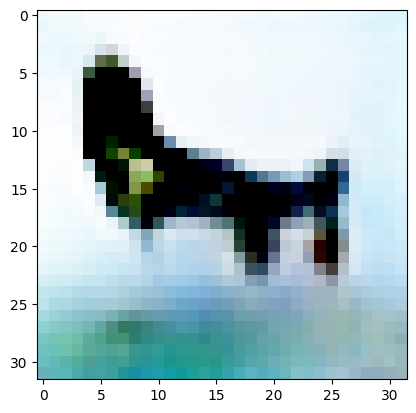

In [101]:
# Visualize the generated images
imgplot = plt.imshow(X_fake[42])
plt.show()


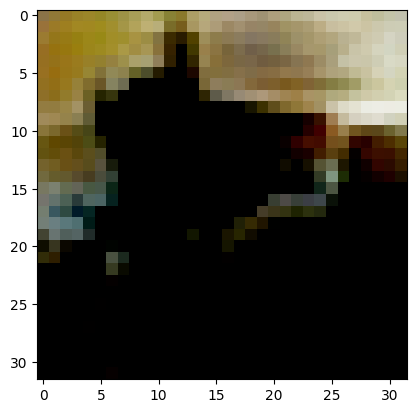

In [89]:
# Visualize the generated images
imgplot = plt.imshow(X_fake[50])
plt.show()

In [68]:
from PIL import Image
import glob

# Set the duration (in milliseconds) for each frame in the GIF
frame_duration = 150

# Fetch a list of image filenames
image_filenames = glob.glob('Plot_epoch_*.png')  # Update the path and file extension as needed

# Create an empty list to store the image frames
frames = []

# Open and append each image to the frames list
for filename in image_filenames:
    img = Image.open(filename)
    frames.append(img)

# Save the frames as a GIF
frames[0].save('Generated images.gif', format='GIF', append_images=frames[1:], save_all=True, duration=frame_duration, loop=1)


# Second-level requirement
Second-level requirement: train and generate images for ONE class of the dataset using the mechanism of ProGAN. In this requirement, you do not need to strictly follow the implementation in the ProGAN paper but feel free to construct a light version (a simple incremental network architecture) of it yourself. NOTE: it is fine to try and fail (i.e., you may not be able to generate good quality images), but at least you give it a try.

In [32]:
# Your code goes here